In [18]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen import EmbeddingGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=0, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

In [4]:
emb_gen = EmbeddingGenerator()
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='vx')

Creating collection
Block 1/2 done
Block 2/2 done
Time to create collection: 43.42339301109314


In [21]:
# get a random page
ids = wiki_dataloader.dataset.get_random_ids(10)
ids

#vdb.client.retrieve(collection_name='vx', ids=ids, with_payload=True, with_vectors=False)

[{'id': 'Bombing_of_Guernica',
  'text': "The bombing of Guernica -LRB- 26 April 1937 -RRB- was an aerial bombing of the Basque town of Guernica during the Spanish Civil War . It was carried out at the behest of Francisco Franco 's nationalist government by its allies , the Nazi German Luftwaffe 's Condor Legion and the Fascist Italian Aviazione Legionaria , under the code name Operation Rügen . The town was being used as a communications center behind the frontline .   The attack gained infamy because it involved the bombing of civilians by a military air force . The number of victims is still disputed ; the Basque government reported 1,654 people killed at the time , while local historians identified 126 victims -LRB- later revised by the authors of the study to 153 -RRB- . An English source used by the Air War College claims 400 civilians died . Russian archives claim 800 deaths on 1 May 1937 , but this number may not include victims who later died of their injuries in hospitals or 

## Real

In [23]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen import EmbeddingGenerator
from nli_55 import NLI_Heads
from validation import Validation
from train import Train
import torch
from other_utils import print_progress

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 5
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=10, num_workers=8, shuffle=True, collate_fn=fever_collator)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, batch_size=64, num_workers=8, shuffle=False, collate_fn=fever_collator)
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=NUM_EXTRA_PAGES, seed=None)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

emb_gen = EmbeddingGenerator()
nli = NLI_Heads()


loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.2)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': emb_gen.parameters(), 'lr': 1e-5},
    {'params': nli.parameters(), 'lr': 1e-4}
], fused=True)

tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
train_fever_loader = DataLoader(train_fever_dataset, batch_size=64, num_workers=8, shuffle=True, collate_fn=fever_collator)

In [ ]:
val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, model_name='test')

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker')
#val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=10, vdb_refresh_rate=500000)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    #val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    vdb.refresh(emb_gen)

## Real 2

In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen_gte import EmbeddingGenerator
from nli_13 import NLI_Heads_13M
from validation2 import Validation
from train2 import Train
from other_utils import print_progress
import torch
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 15
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(eval_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = NLI_Heads_13M(device=device)


loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.25)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': emb_gen.parameters(), 'lr': 1e-6},
    {'params': nli.parameters(), 'lr': 1e-4}
], fused=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=0, verbose=True)


tracking_eval = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

In [2]:
val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, model_name='v1')

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='vy')
val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)
strike_one = False
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=128, ma_ratio=0.1)
    val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    scheduler.step(tracking_eval['average_total_loss'][-1])
    # save the metrics
    with open('metrics/tracking_train_v2.json', 'w') as f:
        json.dump(tracking_train, f)
    with open('metrics/tracking_eval_v2.json', 'w') as f:
        json.dump(tracking_eval, f)
        
    # save the model if it is the best one, return True if it is not to stop the training
    if tracking_eval['overall_accuracy'][-1] == max(tracking_eval['overall_accuracy']):
        torch.save(emb_gen.state_dict(), 'models/emb_gen_v2.pth')
        torch.save(nli.state_dict(), 'models/nli_v2.pth')
        torch.save(optimizer.state_dict(), 'models/optimizer_v2.pth')
        torch.save(scheduler.state_dict(), 'models/scheduler_v2.pth')
    else:
        if strike_one:
            break
        strike_one = True

Creating collection
Block 1/661 done
Block 2/661 done
Block 3/661 done
Block 4/661 done
Block 5/661 done
Block 6/661 done
Block 7/661 done
Block 8/661 done
Block 9/661 done
Block 10/661 done
Block 11/661 done
Block 12/661 done
Block 13/661 done
Block 14/661 done
Block 15/661 done
Block 16/661 done
Block 17/661 done
Block 18/661 done


# Test

In [3]:
## load the models
emb_gen.load_state_dict(torch.load('models/emb_gen_v1.pth'))
nli.load_state_dict(torch.load('models/nli_v1.pth'))

<All keys matched successfully>

In [19]:
# evaluate on the test set
tracking_test = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

test_fever_dataset = FeverDataset(type='test')
test_fever_loader = DataLoader(test_fever_dataset, len(test_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
test = Validation(device=device, eval_loader=test_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test')
test.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_test)
print(tracking_test)

{'nli_accuracy': [0.689018901890189, 0.697919791979198, 0.6999199919992], 'nli_f1': [0.6366351521755622, 0.6381960657065836, 0.6379964580495132], 'overall_accuracy': [0.6668666866686669, 0.673967396739674, 0.6722172217221722], 'overall_f1': [0.6321445465961149, 0.6324102551241131, 0.6281690430889518], 'average_enough_retrieved': [0.9275427542754275, 0.92994299429943, 0.9305930593059306], 'average_total_retrieved': [0.8520910000451714, 0.8555006267221252, 0.8583384105005029], 'average_loss1': [0.27073885709904255, 0.26886292382741506, 0.2676309596616239], 'average_loss2': [0.5781226050549041, 0.5953079941935433, 0.6365552734071835], 'average_total_loss': [0.848861460868543, 0.8641709174972754, 0.9041862341161734]}


In [20]:
# with open('metrics/tracking_test_v1.json', 'w') as f:
#     json.dump(tracking_test, f)

# NLI Test

In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen import EmbeddingGenerator
from nli_13 import NLI_FullLinear_13M, NLI_PairsBasic_13M, NLI_Heads_13M, NLI_MiniHeads_13M
from nli_3 import NLI_FullLinear_3M, NLI_PairsBasic_3M, NLI_Heads_3M, NLI_MiniHeads_3M
from NLI_tests.validation2 import Validation
from NLI_tests.train2 import Train
from NLI_tests.other_utils import print_progress
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 4
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(train_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = [NLI_FullLinear_13M(device=device), NLI_PairsBasic_13M(device=device), NLI_Heads_13M(device=device), NLI_MiniHeads_13M(device=device),
       NLI_FullLinear_3M(device=device), NLI_PairsBasic_3M(device=device), NLI_Heads_3M(device=device), NLI_MiniHeads_3M(device=device)]

loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.25)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': nli[i].parameters(), 'lr': 1e-4} for i in range(len(nli))
], fused=True)


tracking_eval = {'nli_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss2':  [],}


tracking_train = { 'nli_f1': [], 
                 'average_enough_retrieved': [],
                 'average_total_retrieved': [],
                 'average_loss2':  [],}

In [2]:
emb_gen.load_state_dict(torch.load('models/emb_gen_v1.pth'))

<All keys matched successfully>

In [3]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')

val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, model_name='test', vdb=vdb, emb_gen=emb_gen)
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, model_name='v1', vdb=vdb, emb_gen=emb_gen)

Collection already exists


Epoch: 0
Batch: 1/1


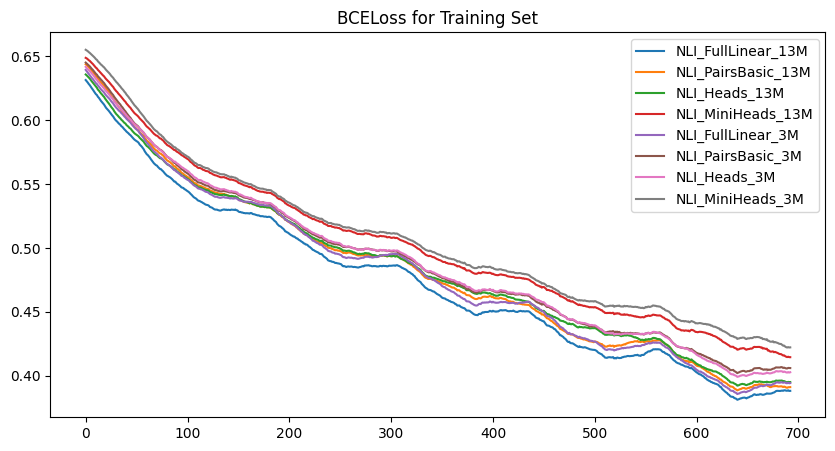

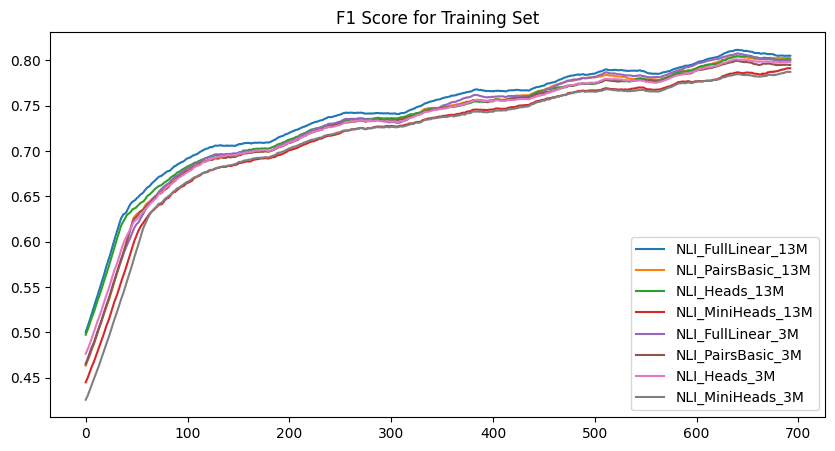

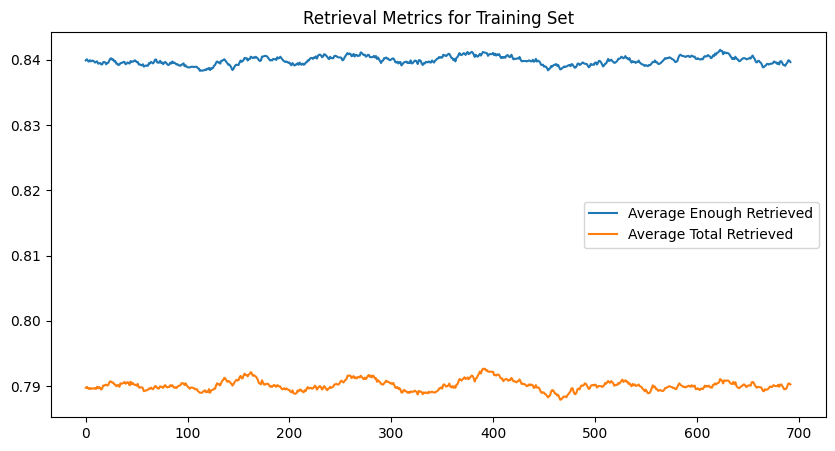

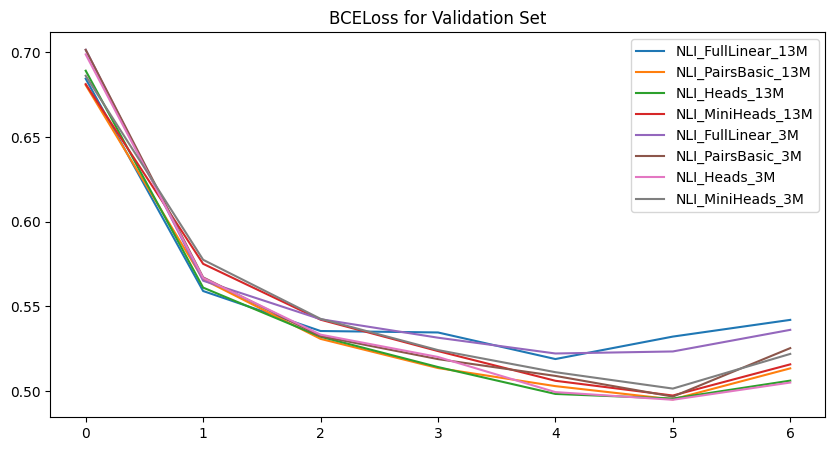

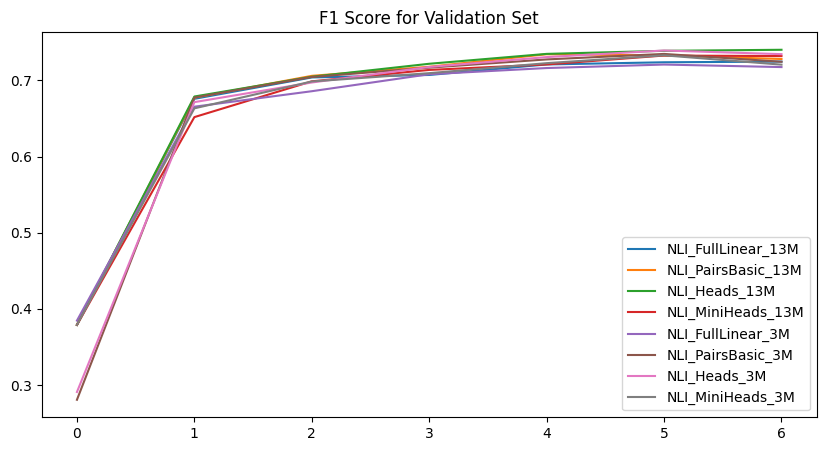

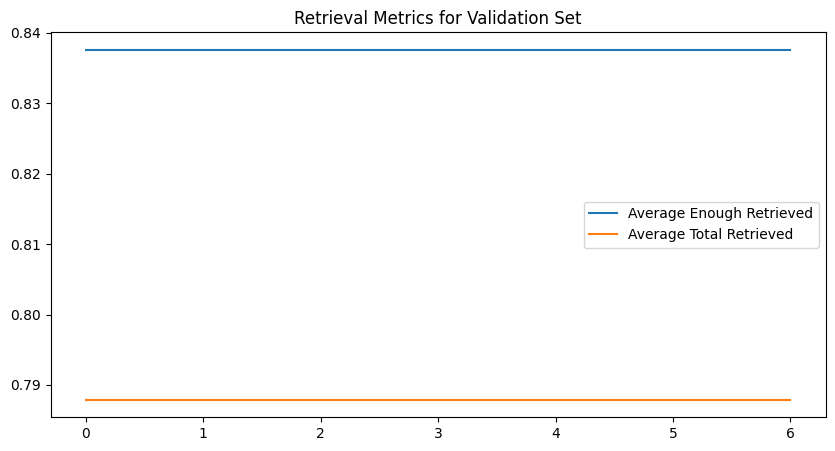

In [6]:
#val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
for epoch in range(2):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=128, ma_ratio=0.1)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)

In [7]:
import json

with open('NLI_tests/results/tracking_train_v13_v3.json', 'w') as f:
    json.dump(tracking_train, f)

with open('NLI_tests/results/tracking_eval_v13_v3.json', 'w') as f:
    json.dump(tracking_eval, f)